# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file, extracting the ~ *data* ~, and converting the image to counts:

In [4]:
image_file = 'example_data/PAL5_3p6um.fits'
#image_file = 'data/PAL5/PAL5__e7/PAL5__e7_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

#print(hdr)
w = wcs.WCS(hdr)
print(w)
#w.wcs.print_contents()

pixcrd = np.array([[300, 300], [360, 550], [600, 250]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)
print(world)

EXPTIME: 969.101928711
FLUXCONV: 0.1469
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.025603  -0.055354  
CRPIX : 707.984856  349.128859  
CD1_1 CD1_2  : -2.69158778194532e-05  -0.000164482292120484  
CD2_1 CD2_2  : -0.000164482292120484  2.69158778194532e-05  
NAXIS : 1415  697
[[ 2.29044474e+02  1.02923422e-02]
 [ 2.29001738e+02  7.15237799e-03]
 [ 2.29044623e+02 -4.03981082e-02]]


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [3]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

Plotting the number of stars detected across a range of sigma values, allowing us to estimate the best sigma level to use:

In [4]:
mean, median, std = sigma_clipped_stats(data, sigma=4.) # don't need mean any more?

In [5]:
#no_detected = []
#sigma_vals = []
#fwhm = 5.

#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = fwhm)
#    sources = daofind(data - median)
#    #print(len(sources))
    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)

#print(no_detected)
#print(sigma_vals)

In [6]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)

#plt.savefig('images/sigma_curve_fwhm5.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

1036


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


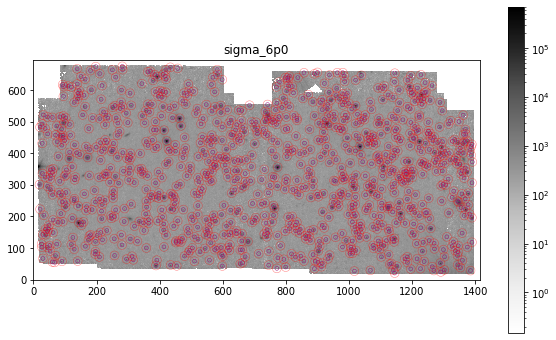

In [7]:
sigma_level = 6.

# 4 sigma seems ideal to me
# fwhm = 3. is roughly the average of many stars tested with imexam (using 1d gaussian fit)
# vicky uses radial fwhm, which varies between 4 - 6 ish; mean is ~4.9, so i'll try 5
# i like the roundness limits at +/- 0.5 personally

#daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5.)
daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5., roundlo = -0.5, roundhi = 0.5)
sources = daofind(data - median)   # think: do i need to subtract bkg here? or later?

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

plotname = str(int(sigma_level)) + 'p' + str(int(10 * (sigma_level - int(sigma_level))))
plt.title('sigma_' + plotname)
#plt.savefig('images/sigma_' + plotname, dpi=500)

print(len(sources))

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures are where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli are where annuli overlap)

In [8]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id   xcenter   ycenter  aperture_sum_0 aperture_sum_1
        pix       pix                                 
---- --------- --------- -------------- --------------
   1 1144.9179  20.43013            nan            nan
   2 1291.0274  23.95022            nan            nan
   3 1017.0781 26.568878      45426.009            nan
   4 1067.8531 28.996855      39140.999            nan
   5 1269.3064 28.508046      92600.996            nan
   6 1385.3451 28.346766      79482.332            nan
   7 1140.1015  29.89543      68500.187            nan
   8 1302.3473 30.397221      157679.29            nan
   9 1195.8439 33.438245       53623.98      205708.91
  10 890.51598 34.531882      36458.956      158436.58
 ...       ...       ...            ...            ...
1027 180.68996 662.27167      44082.032      153439.17
1028 250.27467 664.54277      46311.105      139137.88
1029 419.91637 664.48844      89771.622      196074.14
1030 282.68834 665.26201      50652.112      146751.56
1031 582.4

Estimating the local background in the annuli by finding the mean brightness within:

In [9]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
phot_table['bkg_sum'] = bkg_sum
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(phot_table)

 id   xcenter   ycenter  ... aperture_sum_1  bkg_sum  residual_sum_mean
        pix       pix    ...                                           
---- --------- --------- ... -------------- --------- -----------------
   1 1144.9179  20.43013 ...            nan       nan               nan
   2 1291.0274  23.95022 ...            nan       nan               nan
   3 1017.0781 26.568878 ...            nan       nan               nan
   4 1067.8531 28.996855 ...            nan       nan               nan
   5 1269.3064 28.508046 ...            nan       nan               nan
   6 1385.3451 28.346766 ...            nan       nan               nan
   7 1140.1015  29.89543 ...            nan       nan               nan
   8 1302.3473 30.397221 ...            nan       nan               nan
   9 1195.8439 33.438245 ...      205708.91 46284.504         7339.4755
  10 890.51598 34.531882 ...      158436.58 35648.231         810.72516
 ...       ...       ... ...            ...       ...           

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [10]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

WARNING

 id   xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
        pix       pix    ...                                         
---- --------- --------- ... -------------- --------- ---------------
   1 1144.9179  20.43013 ...      433.71738  49052.28             nan
   2 1291.0274  23.95022 ...      847.65802 95867.864             nan
   3 1017.0781 26.568878 ...      322.16389 36435.878       8990.1305
   4 1067.8531 28.996855 ...      367.43985 41556.468      -2415.4691
   5 1269.3064 28.508046 ...      639.80017 72359.695       20241.301
   6 1385.3451 28.346766 ...      721.47681 81597.104      -2114.7724
   7 1140.1015  29.89543 ...      408.88469 46243.769       22256.418
   8 1302.3473 30.397221 ...      896.03735 101339.44       56339.852
   9 1195.8439 33.438245 ...      415.22125 46960.417       6663.5627
  10 890.51598 34.531882 ...      311.82309 35266.361       1192.5956
 ...       ...       ... ...            ...       ...             ...
1027 180.68996 662.2

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


Trying to calculate the apparent magnitudes of each star:

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [11]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
conv = fluxconv / exptime
negative_sums = []

phot_table['apparent_mag_mean'] = float('NaN')
phot_table['apparent_mag_median'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works

for i in range(0, len(phot_table)):
    if phot_table['residual_sum_mean'][i] >= 0:
        phot_table['apparent_mag_mean'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['residual_sum_mean'][i])
    if phot_table['aper_sum_bkgsub'][i] >= 0:
        phot_table['apparent_mag_median'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['aper_sum_bkgsub'][i])
    else:
        negative_sums.append(phot_table['id'][i])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
#print(negative_sums)

print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_mean'])))
print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_median'])))

 id   xcenter   ycenter  ... apparent_mag_mean apparent_mag_median
        pix       pix    ...                                      
---- --------- --------- ... ----------------- -------------------
   1 1144.9179  20.43013 ...               nan                 nan
   2 1291.0274  23.95022 ...               nan                 nan
   3 1017.0781 26.568878 ...               nan           18.336073
   4 1067.8531 28.996855 ...               nan                 nan
   5 1269.3064 28.508046 ...               nan           17.454892
   6 1385.3451 28.346766 ...               nan                 nan
   7 1140.1015  29.89543 ...               nan            17.35185
   8 1302.3473 30.397221 ...               nan           16.343449
   9 1195.8439 33.438245 ...         18.556325           18.661222
  10 890.51598 34.531882 ...         20.948304           20.529255
 ...       ...       ... ...               ...                 ...
1027 180.68996 662.27167 ...         18.269545           18.29

In [16]:
phot_table['id', 'xcenter', 'ycenter', 'apparent_mag_median'].write('outputs/apphot_test01.txt', format='csv', overwrite=True)

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 3.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
         0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,
         2.,  2.,  0.,  1.,  3.,  2.,  2.,  2.,  2.,  1.,  0.,  2.,  2.,
         1.,  3.,  0.,  0.,  1.,  1.,  3.,  3.,  4.,  2.,  1.,  2.,  3.,
         0.,  3.,  4.,  6.,  4.,  4.,  4.,  7.,  2.,  5.,  6.,  5.,  5.,
         3.,  6.,  7.,  6.,  3., 13.,  7.,  7., 10., 12.,  9.,  6., 15.,
         5., 22., 12., 15., 14., 12., 13., 13., 14., 15., 12., 13., 10.,
        20., 17., 19., 18., 14., 18., 16., 17., 12., 13., 16., 25., 16.,
        19., 15., 12., 12.,  9.,  9., 15., 14., 11., 10., 12.,  8.,  5.,
         4.,  4., 10.,  6.,  5.,  2.,  1.,  3.,  4.,  4.,  2.,  1.,  1.,
         3.,  4.,  4.,  2.,  2.,  0.,  1.,  2.,  2.,  2.,  5.,  1.,  1.,
         0.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  0.,  3.,  0.,  1.,  0.,  0.

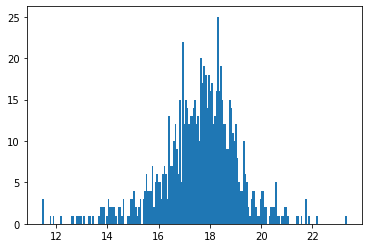

In [13]:
plt.hist(phot_table['apparent_mag_mean'], bins=200)
#plt.hist(phot_table['apparent_mag_median'], bins=200)

In [37]:
#filename_ap = 'outputs/apphot_test01.txt'
#filename_psf = 'outputs/psf_test01.txt'
#file_ap = np.genfromtxt(filename_ap, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)
#file_psf = np.genfromtxt(filename_psf, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)

[(   1, 1144.9179 ,  20.43013 ,       nan)
 (   2, 1291.0274 ,  23.95022 ,       nan)
 (   3, 1017.0781 ,  26.568878, 18.336073) ...
 (1034,  433.76179, 672.58093 , 15.627514)
 (1035,  197.31713, 674.78282 ,       nan)
 (1036,  281.55497, 675.62985 ,       nan)]
(1036,)


IndexError: too many indices for array

In [ ]:
#print(file_ap)
#print(np.shape(file_ap))

#mag_ap = []
#mag_ap = file_ap[:,3]
#print(mag_ap)

#testy = np.insert(file_ap, )

In [ ]:
#t = Table.write(phot_table, 'outputs/table_test_ap.', delimiter=',', format='ascii')